# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.905018,False,-2.433148
1,-0.124547,True,3.915287
2,0.089758,True,6.179269
3,-0.484915,False,-1.054701
4,-1.626700,False,-4.806516
...,...,...,...
995,-0.715328,False,-2.540384
996,0.786575,True,7.502960
997,-0.097893,True,4.660949
998,-0.615763,True,1.487344


<AxesSubplot:xlabel='v0'>

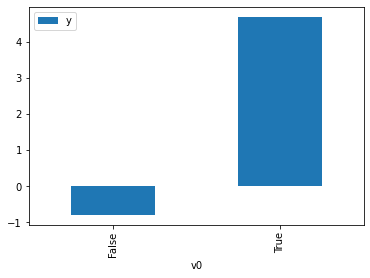

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

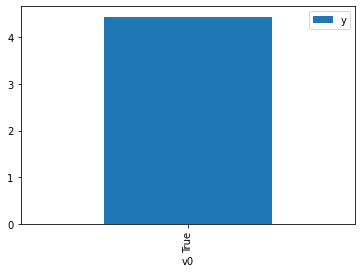

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.346620,False,-0.638880,0.685010,1.459832
1,-1.725579,False,-4.885031,0.980858,1.019516
2,0.495733,False,0.886080,0.239906,4.168307
3,-0.889630,False,-4.007824,0.882995,1.132510
4,-0.604778,False,-2.732753,0.797124,1.254510
...,...,...,...,...,...
995,-0.167716,False,0.589118,0.590727,1.692830
996,0.527682,False,2.246744,0.226812,4.408944
997,0.495733,False,0.886080,0.239906,4.168307
998,-0.838598,False,-3.857619,0.870363,1.148946


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.087631,True,4.019010,0.554312,1.804037
1,1.277760,True,9.909575,0.950030,1.052599
2,0.933066,True,7.409383,0.896160,1.115873
3,0.570924,True,6.309402,0.790092,1.265675
4,0.933066,True,7.409383,0.896160,1.115873
...,...,...,...,...,...
995,0.326924,True,5.231477,0.682742,1.464682
996,0.404134,True,5.751257,0.719769,1.389335
997,-1.637847,True,1.027376,0.023305,42.908798
998,-0.727507,True,3.389506,0.161160,6.205026


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                          1.224e+04
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:56:25   Log-Likelihood:                         -1461.1
No. Observations:                1000   AIC:                                      2926.
Df Residuals:                     998   BIC:                                      2936.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9960      0.033     90.655      0.000       2.931       3.061
x2             5.0231      0.054     93.765      0.000       4.918       5.128
==============================================================================
Omnibus:                        1.852   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.396   Jarque-Bera (JB):                1.802
Skew:                          -0.037   Prob(JB):                        0.406
Kurtosis:                       3.195   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""